In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np

from argparse import Namespace
from pathlib import Path

import torch
from pytorch_lightning.trainer import Trainer, seed_everything
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

from turboflow.dataloaders import TurboFlowDataModule
from turboflow.evaluation import compute_all_metrics

from turboflow.utils import phy_utils as phy
from turboflow.utils import torch_utils as tch

from kornia.filters import SpatialGradient

In [4]:
seed_everything(42, workers=True)

Global seed set to 42


42

In [5]:
# load dataset
data_dir = Path('/','home','dicarlo_d','Documents','Datasets','Turb2D.hdf5')
dm = TurboFlowDataModule(dataset='Turb2D', 
                         data_dir=data_dir,
                         batch_size=100000,
                         time_idx=[32,33],
                         train_downsampling=4,
                         val_downsampling=4,
                         test_downsampling=1,
                         num_workers=1)
dm.setup()

In [6]:
# choose the hyperparams
hparams = {
    'name':'RFFNet',
    'mlp_layers_num': 3,
    'mlp_layers_dim': 256, 
    'mlp_last_actfn': 'tanh',
    'do_rff': True, 
    'rff_num': 1024, 
    'rff_scale': 10,
    'do_divfree': True,
    'lam_pde': 0,  # soft constr. grad(u,v)=0
    'lam_div': 0,     # spatial grad(u,v) = torch.autograd(u,v)
    'lam_reg': 0,     # offgrid L2 reg. on grad of the potential
    'lam_sfn': 0,     # offgrid L2 reg. on Sfun
    'lam_spec': 0,    # L2 reg on the spectrum
    'lam_weight': 1,  # L2 reg on the NN's weights
    'sfn_min_x': 0.00784314,
    'sfn_num_centers': 50,
    'sfn_num_increments':3,
    'sfn_patch_dim': 30
}

In [10]:
X_lr, y_lr = dm.val_dataset[:]
img_shape_lr = dm.val_dataset.img_shape[:2]
shape_lr = dm.val_dataset.img_shape

X_hr, y_hr = dm.test_dataset[:]
img_shape_hr = dm.test_dataset.img_shape[:2]
shape_hr = dm.test_dataset.img_shape

print(X_lr.shape, y_lr.shape)
print(X_hr.shape, y_hr.shape)
print(img_shape_hr)

torch.Size([8192, 3]) torch.Size([8192, 2])
torch.Size([131072, 3]) torch.Size([131072, 2])
(256, 256)


In [26]:
X_hr = X_hr.reshape(2,*img_shape_hr,3)
y_hr = y_hr.reshape(2,*img_shape_hr,2)

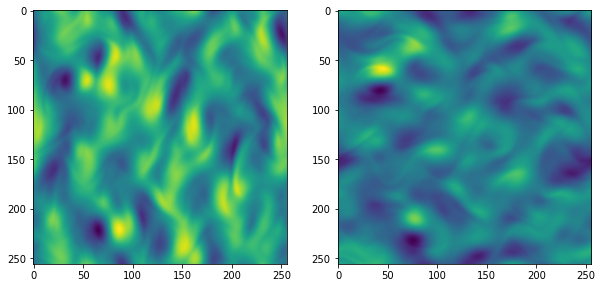

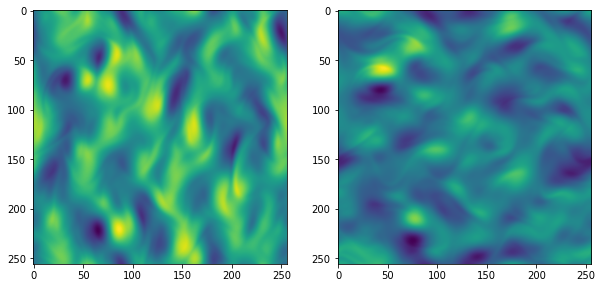

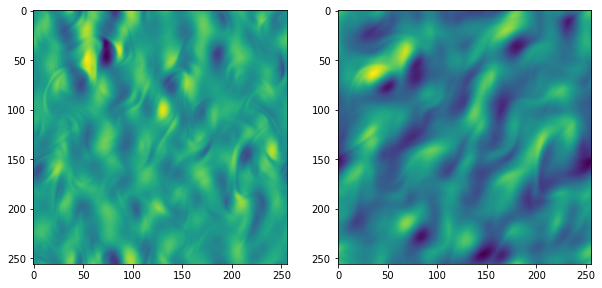

In [30]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(y_hr[0,:,:,0].detach())
plt.subplot(122)
plt.imshow(y_hr[0,:,:,1].detach())
plt.show()

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(y_hr[1,:,:,0].detach())
plt.subplot(122)
plt.imshow(y_hr[1,:,:,1].detach())
plt.show()

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(y_hr[1,:,:,0] - y_hr[0,:,:,0].detach())
plt.subplot(122)
plt.imshow(y_hr[1,:,:,1] - y_hr[0,:,:,0].detach())
plt.show()


In [31]:
grad1 = SpatialGradient(mode='diff',order=1, normalized=False)
grad2 = SpatialGradient(mode='diff',order=2, normalized=False)

torch.Size([1, 2, 256, 256])
torch.Size([1, 2, 2, 256, 256])
torch.Size([256, 256])


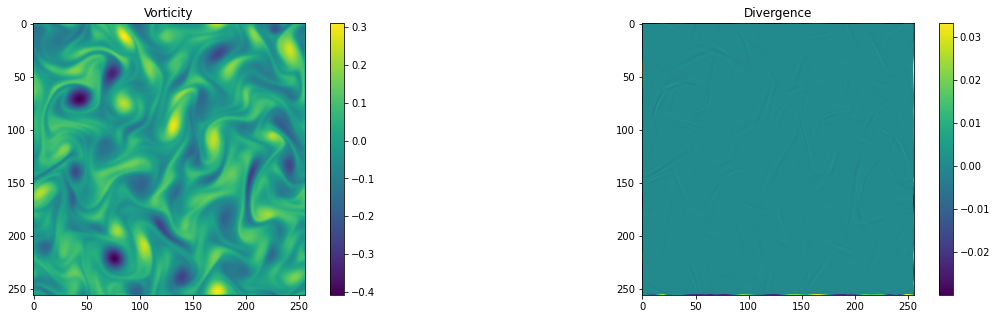

In [44]:
uv = y_hr[None,0, :, :, :2].permute(0,3,1,2)

print(uv.shape)
duv_dxy = grad1(uv)
print(duv_dxy.shape)
du_dx = duv_dxy[0,0,1,:,:]
du_dy = duv_dxy[0,0,0,:,:]
dv_dx = duv_dxy[0,1,1,:,:]
dv_dy = duv_dxy[0,1,0,:,:]

w0 = dv_dx - du_dy
print(w.shape)

d0 = du_dx + dv_dy

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Vorticity')
plt.imshow(w0)
plt.colorbar()
plt.subplot(122)
plt.title('Divergence')
plt.imshow(d0)
plt.colorbar()
plt.show()

torch.Size([1, 2, 256, 256])
torch.Size([1, 2, 2, 256, 256])
torch.Size([256, 256])


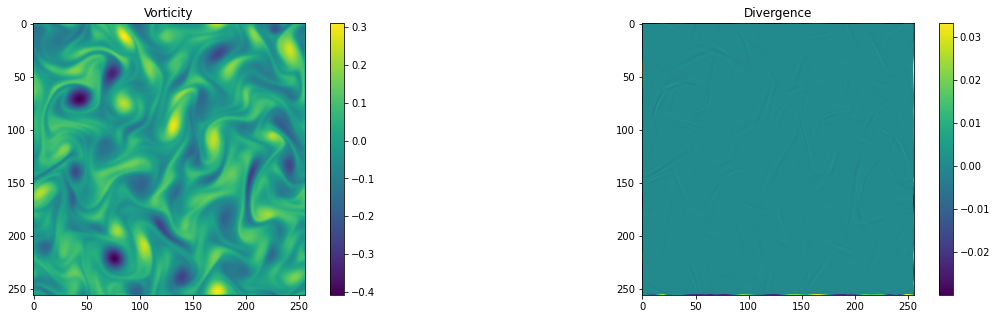

In [45]:
uv = y_hr[None,1, :, :, :2].permute(0,3,1,2)

print(uv.shape)
duv_dxy = grad1(uv)
print(duv_dxy.shape)
du_dx = duv_dxy[0,0,1,:,:]
du_dy = duv_dxy[0,0,0,:,:]
dv_dx = duv_dxy[0,1,1,:,:]
dv_dy = duv_dxy[0,1,0,:,:]

w1 = dv_dx - du_dy
print(w.shape)

d1 = du_dx + dv_dy

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Vorticity')
plt.imshow(w0)
plt.colorbar()
plt.subplot(122)
plt.title('Divergence')
plt.imshow(d0)
plt.colorbar()
plt.show()

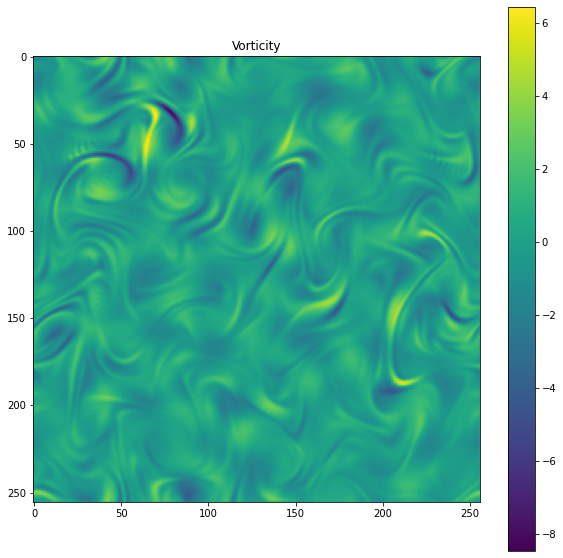

In [60]:
plt.figure(figsize=(10,10))
plt.title('Vorticity')
plt.imshow((w1-w0)/0.01)
plt.colorbar()

torch.Size([1, 1, 2, 256, 256])


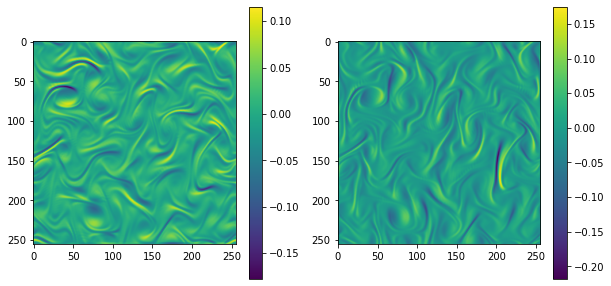

torch.Size([1, 1, 2, 256, 256])


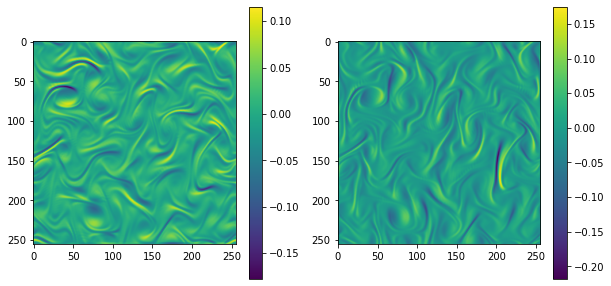

In [48]:
dw_dxy = grad1(w0[None,None,:,:])
print(dw_dxy.shape)
dw_dx0 = dw_dxy[0,0,1,:,:]
dw_dy0 = dw_dxy[0,0,0,:,:]

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(dw_dx)
plt.colorbar()
plt.subplot(122)
plt.imshow(dw_dy)
plt.colorbar()
plt.show()

dw_dxy = grad1(w1[None,None,:,:])
print(dw_dxy.shape)
dw_dx1 = dw_dxy[0,0,1,:,:]
dw_dy1 = dw_dxy[0,0,0,:,:]

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(dw_dx)
plt.colorbar()
plt.subplot(122)
plt.imshow(dw_dy)
plt.colorbar()
plt.show()

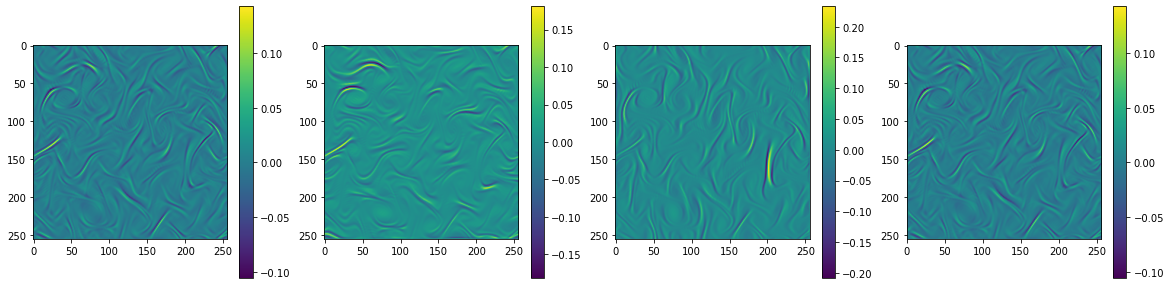

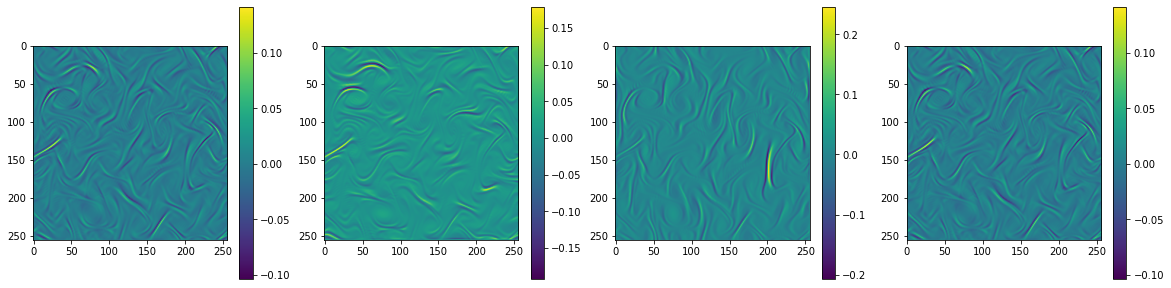

In [49]:
dw_dx_dxy = grad1(dw_dx0[None,None,...])
dw_dy_dxy = grad1(dw_dy0[None,None,...])

plt.figure(figsize=(20,5))
plt.subplot(141)
plt.imshow(dw_dx_dxy[0,0,0,:,:])
plt.colorbar()
plt.subplot(142)
plt.imshow(dw_dx_dxy[0,0,1,:,:])
plt.colorbar()
plt.subplot(143)
plt.imshow(dw_dy_dxy[0,0,0,:,:])
plt.colorbar()
plt.subplot(144)
plt.imshow(dw_dy_dxy[0,0,1,:,:])
plt.colorbar()
plt.show()

d2w_dx20 = dw_dx_dxy[0,0,1,...]
d2w_dy20 = dw_dy_dxy[0,0,0,...]

dw_dx_dxy = grad1(dw_dx1[None,None,...])
dw_dy_dxy = grad1(dw_dy1[None,None,...])

plt.figure(figsize=(20,5))
plt.subplot(141)
plt.imshow(dw_dx_dxy[0,0,0,:,:])
plt.colorbar()
plt.subplot(142)
plt.imshow(dw_dx_dxy[0,0,1,:,:])
plt.colorbar()
plt.subplot(143)
plt.imshow(dw_dy_dxy[0,0,0,:,:])
plt.colorbar()
plt.subplot(144)
plt.imshow(dw_dy_dxy[0,0,1,:,:])
plt.colorbar()
plt.show()

d2w_dx21 = dw_dx_dxy[0,0,1,...]
d2w_dy21 = dw_dy_dxy[0,0,0,...]

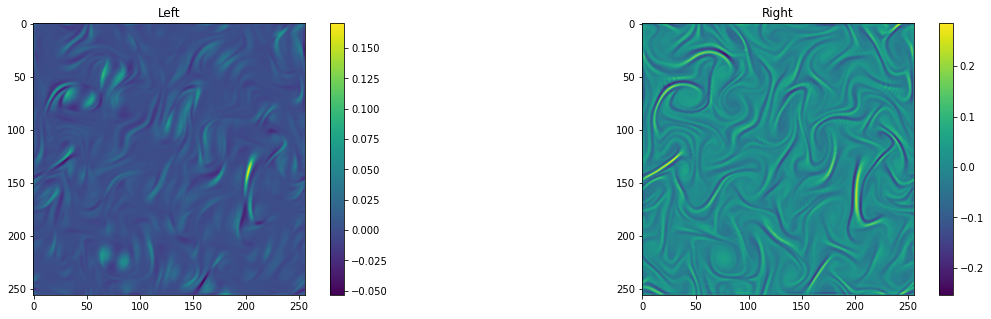

In [52]:
# spatial change of vorticity / unit volume (u dot Nabla)w
left1 = u*dw_dx1 + v*dw_dy1
# diffusion of vorticity / univ volume (nu Laplacian w)
right1 = d2w_dx21 + d2w_dy21

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Left')
plt.imshow(left1)
plt.colorbar()
plt.subplot(122)
plt.title('Right')
plt.imshow(right1)
plt.colorbar()
plt.show()

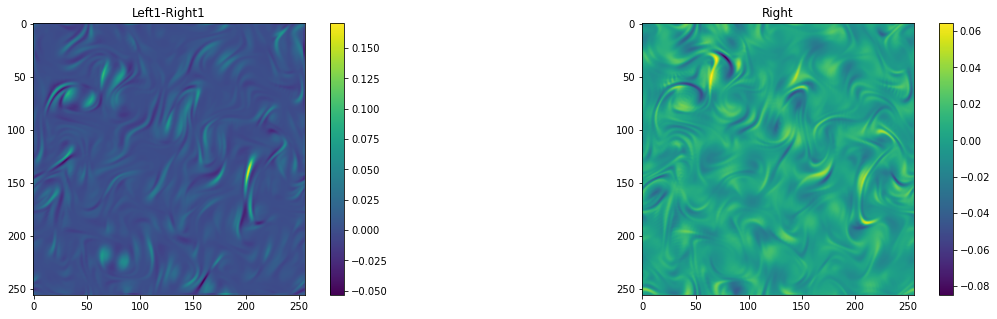

In [57]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Left1-Right1')
plt.imshow(left1+(1./3000)*right1)
plt.colorbar()
plt.subplot(122)
plt.title('Right')
plt.imshow(w1-w0)
plt.colorbar()
plt.show()